Reference: https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/NLP/DeBERTa%20Fine%20Tuning-for%20Amazon%20Review%20Dataset%20Pytorch.ipynb

In [ ]:
!pip install colorama

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00


In [ ]:
import os
import gc
import copy
import time
import random
import string
import joblib

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

# Utils
from tqdm import tqdm
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding

In [ ]:
df = pd.read_csv('/content/reddit_posts_comments_labeled.csv')
df.head()

,Post ID,Post Date,Content,Type,Label
0,1523952,2023-07-17,Dolores Catania wants to lose weight with a dr...,post,NEUTRAL
1,15235ut,2023-07-17,Peeps who are on Ozempic who are also prescrib...,post,NEUTRAL
2,1523582,2023-07-17,How do you know? I have been pre diabetic for ...,post,NEGATIVE
3,1522hqt,2023-07-17,Another GI issue post Hi! I know we’ve all exp...,post,NEUTRAL
4,1522hkq,2023-07-17,BCBS Market Place Happy Monday! My step-dad wh...,post,NEUTRAL


In [ ]:
df['ID'] = (df['Content']+df['Post ID']).map(hash)
df.head()

,Post ID,Post Date,Content,Type,Label,ID
0,1523952,2023-07-17,Dolores Catania wants to lose weight with a dr...,post,NEUTRAL,5223773858043651984
1,15235ut,2023-07-17,Peeps who are on Ozempic who are also prescrib...,post,NEUTRAL,1327328492310719353
2,1523582,2023-07-17,How do you know? I have been pre diabetic for ...,post,NEGATIVE,-2601613728136490058
3,1522hqt,2023-07-17,Another GI issue post Hi! I know we’ve all exp...,post,NEUTRAL,424251320753452433
4,1522hkq,2023-07-17,BCBS Market Place Happy Monday! My step-dad wh...,post,NEUTRAL,-6370630733328643768


In [ ]:
 df[df['ID'].duplicated() == True]

,Post ID,Post Date,Content,Type,Label,ID


# Remove Emojis

In [ ]:
import re

In [ ]:
df.iloc[1115,2]

'I figured I’m saving almost $600/month not drinking wine anymore (hubs has stopped drinking with me).  So the $997 out of pocket for Oz is really about $397/month lol 🤷🏼\u200d♀️😂'

In [ ]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data).strip()

In [ ]:
print(remove_emojis(df.iloc[1115,2])) # no emoji

I figured I’m saving almost $600/month not drinking wine anymore (hubs has stopped drinking with me).  So the $997 out of pocket for Oz is really about $397/month lol


In [ ]:
df['Content'] = df['Content'].apply(lambda x: remove_emojis(x))

In [ ]:
print('df.shape ', df.shape)
nan_count = df['Content'].isna().sum()

nan_count

df.shape  (1124, 6)


0

# Split into Train and Test

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test =  train_test_split(df, test_size=0.1,
                                                    random_state=0,
                                                    stratify=df['Label'])

In [ ]:
len(df_train), len(df_test)

(1011, 113)

In [ ]:
df_train.pivot_table(index='Label',aggfunc = 'count').apply(lambda x: x*100/sum(x))['Content']

Label
NEGATIVE    11.572700
NEUTRAL     62.512364
POSITIVE    25.914936
Name: Content, dtype: float64

In [ ]:
df_test.pivot_table(index='Label',aggfunc = 'count').apply(lambda x: x*100/sum(x))['Content']

Label
NEGATIVE    11.504425
NEUTRAL     62.831858
POSITIVE    25.663717
Name: Content, dtype: float64

In [ ]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# WandB

In [ ]:
!pip install wandb -qU

In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: Currently logged in as: nupur-gokhale23. Use `wandb login --relogin` to force relogin


True

# Stratified Group K Fold

In [ ]:
df_train['group'] = df_train['Post ID'].factorize()[0]

In [ ]:
df_train.head()

,Post ID,Post Date,Content,Type,Label,ID,group
0,150nf2d,2023-07-15,Did you need a diabetes diagnosis to get the e...,comment,NEUTRAL,-7090442856711230395,0
1,14zxymc,2023-07-15,You have the Libre 3 to warn you if you’re goi...,comment,NEUTRAL,-1976752810788411007,1
2,14zxs9p,2023-07-15,I know I’ve slowed down a lot too. 37F 5’3” SW...,comment,POSITIVE,-3722788583162062944,2
3,14zug3r,2023-07-14,"What a great drop in your A1C, congratulations...",comment,POSITIVE,1553768808765057178,3
4,151wga0,2023-07-17,Buy some extra needles on Amazon. 4mm 32ga. Ab...,comment,NEUTRAL,9148904874383576550,4


In [ ]:
df_train[df_train['Post ID']=='14zxs9p']

,Post ID,Post Date,Content,Type,Label,ID,group
2,14zxs9p,2023-07-15,I know I’ve slowed down a lot too. 37F 5’3” SW...,comment,POSITIVE,-3722788583162062944,2
23,14zxs9p,2023-07-15,How long have you been on Wegovy? I am also 37...,comment,NEUTRAL,-5785316395140767980,2
636,14zxs9p,2023-07-15,So glad you posted! I am 5’ 3” as well startin...,comment,POSITIVE,3942369241152358827,2
800,14zxs9p,2023-07-15,The slow down Hi all- was wondering where some...,post,NEUTRAL,-4501873172859535744,2


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=4)

In [ ]:
for fold, (_, val_index) in enumerate(sgkf.split(X=df_train, y= df_train['Label'], groups=df_train['group'])):
    df_train.loc[val_index, "kfold"] = int(fold)

df_train["kfold"] = df_train["kfold"].astype(int)
df_train.head()

,Post ID,Post Date,Content,Type,Label,ID,group,kfold
0,150nf2d,2023-07-15,Did you need a diabetes diagnosis to get the e...,comment,NEUTRAL,-7090442856711230395,0,3
1,14zxymc,2023-07-15,You have the Libre 3 to warn you if you’re goi...,comment,NEUTRAL,-1976752810788411007,1,3
2,14zxs9p,2023-07-15,I know I’ve slowed down a lot too. 37F 5’3” SW...,comment,POSITIVE,-3722788583162062944,2,0
3,14zug3r,2023-07-14,"What a great drop in your A1C, congratulations...",comment,POSITIVE,1553768808765057178,3,3
4,151wga0,2023-07-17,Buy some extra needles on Amazon. 4mm 32ga. Ab...,comment,NEUTRAL,9148904874383576550,4,0


In [ ]:
df_train[df_train['Post ID']=='14zxs9p']

,Post ID,Post Date,Content,Type,Label,ID,group,kfold
2,14zxs9p,2023-07-15,I know I’ve slowed down a lot too. 37F 5’3” SW...,comment,POSITIVE,-3722788583162062944,2,0
23,14zxs9p,2023-07-15,How long have you been on Wegovy? I am also 37...,comment,NEUTRAL,-5785316395140767980,2,0
636,14zxs9p,2023-07-15,So glad you posted! I am 5’ 3” as well startin...,comment,POSITIVE,3942369241152358827,2,0
800,14zxs9p,2023-07-15,The slow down Hi all- was wondering where some...,post,NEUTRAL,-4501873172859535744,2,0


In [ ]:
s0 = set(df_train[df_train['kfold']==0]['group'])
s1 = set(df_train[df_train['kfold']==1]['group'])
s2 = set(df_train[df_train['kfold']==2]['group'])
s3 = set(df_train[df_train['kfold']==3]['group'])

In [ ]:
s0.intersection(s1), s0.intersection(s2), s0.intersection(s3),s1.intersection(s2), s1.intersection(s3)

(set(), set(), set(), set(), set())

In [ ]:
df_train.pivot_table(index='Label',columns=['kfold'] ,aggfunc = 'count').apply(lambda x: x*100/sum(x))['Content']

kfold,0,1,2,3
Label,,,,
NEGATIVE,11.764706,11.507937,11.507937,11.507937
NEUTRAL,62.352941,62.698413,62.301587,62.698413
POSITIVE,25.882353,25.793651,26.190476,25.793651


In [ ]:
# Convert from categorical values ('positive', 'negative', 'neutral') to numerical values
encoder = LabelEncoder()
df_train['Label'] = encoder.fit_transform(df_train['Label'])

""" fit_transform() does two things: it first 'fits' the encoder by learning the mapping between classes and integer labels (using the fit method), and then it 'transforms' the input data into its encoded form (using the transform method).

So, fit_transform(df['sentiments']) is learning the mapping from 'positive', 'negative', and 'neutral' to integer labels, and then immediately applying this mapping to df['sentiments'] to produce a new numpy array of encoded labels.

So this above line, replaces the original 'sentiments' column in the dataframe with the newly encoded numpy array. Now, instead of 'positive', 'negative', and 'neutral', this column contains integer labels that represent these classes. """

with open("le.pkl", "wb") as fp:
    joblib.dump(encoder, fp)

In [ ]:
df_train.head()

,Post ID,Post Date,Content,Type,Label,ID,group,kfold
0,150nf2d,2023-07-15,Did you need a diabetes diagnosis to get the e...,comment,1,-7090442856711230395,0,3
1,14zxymc,2023-07-15,You have the Libre 3 to warn you if you’re goi...,comment,1,-1976752810788411007,1,3
2,14zxs9p,2023-07-15,I know I’ve slowed down a lot too. 37F 5’3” SW...,comment,2,-3722788583162062944,2,0
3,14zug3r,2023-07-14,"What a great drop in your A1C, congratulations...",comment,2,1553768808765057178,3,3
4,151wga0,2023-07-17,Buy some extra needles on Amazon. 4mm 32ga. Ab...,comment,1,9148904874383576550,4,0


In [ ]:
df_train['ID'] = df_train['ID'].apply(int)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Post ID    1011 non-null   object
 1   Post Date  1011 non-null   object
 2   Content    1011 non-null   object
 3   Type       1011 non-null   object
 4   Label      1011 non-null   int64 
 5   ID         1011 non-null   int64 
 6   group      1011 non-null   int64 
 7   kfold      1011 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 63.3+ KB


In [ ]:
df_train.head()

,Post ID,Post Date,Content,Type,Label,ID,group,kfold
0,150nf2d,2023-07-15,Did you need a diabetes diagnosis to get the e...,comment,1,-7090442856711230395,0,3
1,14zxymc,2023-07-15,You have the Libre 3 to warn you if you’re goi...,comment,1,-1976752810788411007,1,3
2,14zxs9p,2023-07-15,I know I’ve slowed down a lot too. 37F 5’3” SW...,comment,2,-3722788583162062944,2,0
3,14zug3r,2023-07-14,"What a great drop in your A1C, congratulations...",comment,2,1553768808765057178,3,3
4,151wga0,2023-07-17,Buy some extra needles on Amazon. 4mm 32ga. Ab...,comment,1,9148904874383576550,4,0


# Config

In [ ]:
CONFIG = {"seed": 2022,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 3,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "client": "novo",
          "_wandb_kernel": "react",
          }

In [ ]:
CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def set_seeds(config):
    '''Sets the seed of the entire program so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    seed = config['seed']
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

# Usage
set_seeds(CONFIG)

# Custom DataSet

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.content = df['Content'].values
        self.targets = df['Label'].values
        self.batch_id = df['ID'].values

    def __len__(self):
        return len(self.df)

    """ The __getitem__ method essentially retrieves the data sample (inputs and target) at a specific index and processes it into a format that can be used by the BERT model.
    This method is particularly important because PyTorch's DataLoader class uses this method to create the batches during training and evaluation. When you pass your Dataset to a DataLoader and start iterating over it, the DataLoader will call the __getitem__ method to generate the necessary inputs for your model."""
    def __getitem__(self, index):
        content = self.content[index]
        batch_id = self.batch_id[index]
        text = self.tokenizer.sep_token + " " + content
        # Above line appends the [SEP] token to the start of the review. This is a requirement of the BERT model, which uses the [SEP] token to differentiate between different sentences.

        # The preprocessed text is then tokenized using the encode_plus method of the tokenizer. The tokenized inputs are truncated to a maximum length of self.max_len and the special tokens [CLS] and [SEP] are added to the sequence.
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )

        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index],
            'batch_id': batch_id
        }

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

# Mean Pooling

In [ ]:
class MeanPooling(nn.Module):
    """ The MeanPooling class inherits from the nn.Module class which is the base class for all neural network modules in PyTorch. """
    def __init__(self):
        super(MeanPooling, self).__init__()
        # In above line __init__() is called to initialize the nn.Module parent class.

    def forward(self, last_hidden_state, attention_mask):

        # attention_mask => (batch_size, sequence_length)
        # last_hidden_state represents the output of the transformer model, which is a 3D tensor of shape (batch_size, sequence_length, hidden_size).

        # First, the attention_mask is expanded to match the size of the last_hidden_state:
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float() # => (batch_size, sequence_length, hidden_size).
        # The resulting tensor is of shape (batch_size, sequence_length, hidden_size).
        #  where each [PAD] token is represented by a vector of zeros, and all other tokens are represented by vectors of ones.

        # Then, the last_hidden_state is multiplied by the expanded mask to zero out the embeddings of the [PAD] tokens:
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        # This line computes the sum of the input_mask_expanded along the sequence_length dimension.
        # This sum represents the number of actual (non-padding) tokens in each sequence of the batch.

        # The sum of the mask values is then computed for each sentence:
        # Result: A 2D tensor of shape (batch_size, hidden_size), where each value represents the number of actual tokens (excluding padding tokens) in the corresponding sentence.
        sum_mask = input_mask_expanded.sum(1) #=> (batch_size, hidden_size)

        """ In above line, the sum function with argument 1 is called on input_mask_expanded to compute the sum along the sequence_length dimension. Essentially, this operation is adding up all the 1s for each sequence in the batch, which gives us the number of actual tokens (i.e., non-padding tokens) in each sequence.
        So, sum_mask is a 2D tensor of shape (batch_size, hidden_size), where each value represents the number of actual tokens in the corresponding sequence.

        This is a crucial step in calculating the mean embeddings for each sequence. By summing the mask values, we essentially count the number of valid (non-padding) tokens in each sequence. This count is later used as the denominator when calculating the mean (i.e., sum of token embeddings / number of tokens).

        By only considering non-padding tokens, we ensure the mean embeddings accurately represent the sequence, rather than being skewed by padding tokens that carry no meaningful information.
        """

        # a lower limit is set on the sum_mask values to avoid division by zero:
        # Result: The same tensor as sum_mask, but any value that was originally zero is now 1e-9.
        sum_mask = torch.clamp(sum_mask, min=1e-9)

        #Finally, the mean of the embeddings is computed by dividing the sum of the embeddings by the number of actual tokens:
        mean_embeddings = sum_embeddings / sum_mask

        # Result: A 2D tensor of shape (batch_size, hidden_size), representing the sentence-level embeddings computed as the mean of the token-level embeddings (ignoring padding tokens).
        return mean_embeddings

# Model

In [ ]:
class TextModel(nn.Module):
    def __init__(self, model_name):
        super(TextModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])

    def forward(self, ids, mask):
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

# Loss Function

In [ ]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

# Train Function

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()

    dataset_size = 0
    running_loss = 0.0

    scaler = GradScaler()

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    """ The total argument in tqdm specifies the total number of iterations (or updates to the progress bar). In this case, len(dataloader) is used as the total which is the total number of batches in the dataloader. """
    for step, data in bar:
      with autocast():
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)

        batch_size = ids.size(0)

        outputs = model(ids, mask)

        loss = criterion(outputs, targets)

        """ Gradient accumulation involves accumulating gradients over multiple mini-batches before performing a weight update step.
        And that Gradient accumulation over several forward passes is achieved through the following two lines in the train_one_epoch() function: """
        loss = loss / CONFIG['n_accumulate']
        """ The `backward()` call on the next line calculates the gradients of the loss with respect to model parameters. Importantly, these gradients are not removed after the computation, they remain stored in the .grad attributes of the model parameters.

        BUT Instead of updating the parameters right away, add the computed gradients to the accumulated gradients. This step is repeated for a specified number of mini-batches.   """
        scaler.scale(loss).backward()

        # After accumulating gradients over the desired number of mini-batches, perform the weight update step.
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            # performs the actual parameter update using the accumulated gradients.
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()

    return epoch_loss

# Validation Function

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, valid_data, device, epoch):
  model.eval()
  dataset_size = 0
  running_loss = 0.0

  all_ids = []
  preds = []
  bar = tqdm(enumerate(dataloader), total=len(dataloader))
  for step, data in bar:
    batch_ids = data['batch_id'].cpu().numpy()
    ids = data['input_ids'].to(device, dtype = torch.long)
    mask = data['attention_mask'].to(device, dtype = torch.long)
    targets = data['target'].to(device, dtype=torch.long)

    batch_size = ids.size(0)

    outputs = model(ids, mask)
    all_ids.extend(batch_ids)

    class_outputs = outputs.cpu().numpy().argmax(axis=1)
    preds.extend(class_outputs)

    loss = criterion(outputs, targets)

    running_loss += (loss.item() * batch_size)
    dataset_size += batch_size

    epoch_loss = running_loss / dataset_size

    bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])

  # Prepare output dataframe ---

  pred_df = pd.DataFrame(
      {'ID': all_ids,
       'Predictions': preds})

  valid_pred_df = pd.merge(valid_data, pred_df, on='ID')

  gc.collect()

  return epoch_loss, valid_pred_df

# Run Training

In [ ]:
def run_training(model, optimizer, scheduler, train_loader, valid_loader, valid_data, device, num_epochs, fold):
    """
    Train and validate a PyTorch model for a specified number of epochs.

    Parameters:
    model (torch.nn.Module): The model to train.
    optimizer (torch.optim.Optimizer): The optimizer for the model.
    scheduler (torch.optim.lr_scheduler): The learning rate scheduler.
    train_loader (torch.utils.data.DataLoader): The DataLoader for the training data.
    valid_loader (torch.utils.data.DataLoader): The DataLoader for the validation data.
    valid_data (pd.DataFrame): Validation DataFrame
    device (str): The device to train on ("cpu" or "cuda").
    num_epochs (int): The number of epochs to train for.
    fold (int): The fold number in k-fold cross-validation.

    Returns:
    model (torch.nn.Module): The trained model.
    history (dict): A dictionary containing the training and validation loss for each epoch.
    """
    # To automatically log gradients
    wandb.watch(model, log_freq=100)

    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()


    # Store the initial state of the model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf

    # Store the loss for each epoch
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CONFIG['device'], epoch=epoch)

        val_epoch_loss, valid_pred_df = valid_one_epoch(model, valid_loader, valid_data, device=CONFIG['device'],
                                         epoch=epoch)

        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)

        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})

        # If the validation loss improved, save the model weights
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            # Save validation predictions
            valid_pred_df.to_csv(f'Fold-{fold}-valid-pred.csv')
            print(f"Validation Predictions Saved{sr_}")

        print()

    end = time.time()

     # Print total training time and best validation loss
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [ ]:
def get_dataloader(fold):
    """
    Returns train and validation data loaders for a given fold.

    Args:
        fold (int): The fold number for which to create the data loaders.

    Returns:
        Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]: The train and validation data loaders.
    """
    train_data = df_train[df_train.kfold != fold].reset_index(drop=True)
    valid_data = df_train[df_train.kfold == fold].reset_index(drop=True)

    train_dataset = TextDataset(train_data, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = TextDataset(valid_data, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, valid_data

In [ ]:
from typing import Optional
from torch.optim import Optimizer
from torch.optim.lr_scheduler import (
    _LRScheduler
)

def get_lr_scheduler(optimizer: Optimizer) -> Optional[_LRScheduler]:
    """
    Returns a learning rate scheduler based on the specified configuration.

    Args:
        optimizer (torch.optim.Optimizer): The optimizer for which to get the scheduler.

    Returns:
        torch.optim.lr_scheduler._LRScheduler or None: The learning rate scheduler or None if no scheduler is specified.
    """
    scheduler_type = CONFIG.get('scheduler')

    if scheduler_type == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.get('T_max'), eta_min=CONFIG.get('min_lr'))

    elif scheduler_type == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.get('T_0'), eta_min=CONFIG.get('min_lr'))

    elif scheduler_type is None:
        return None

    else:
        raise ValueError(f"Invalid scheduler specified: {scheduler_type}")

    return scheduler

# Start Training

In [ ]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))

HASH_NAME = id_generator(size=12)
print(HASH_NAME)

wyubu307nj2y


In [ ]:
from colorama import Fore, Back, Style

b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

In [ ]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='Ozempic_SSNLP_v1',
                     config=CONFIG,
                     job_type='Train',
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')

    train_loader, valid_loader, valid_data = get_dataloader(fold=fold)

    model = TextModel(CONFIG['model_name'])
    model.to(CONFIG['device'])

    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = get_lr_scheduler(optimizer)

    model, history = run_training(model, optimizer, scheduler, train_loader, valid_loader, valid_data,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold, )

    run.finish()

    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

====== Fold: 0 ======


Train Loss,█▆▄▃▂▂▁▁
Valid Loss,▆▁▃▁▂▃▅█
Best Loss,0.66207
Train Loss,0.14193
Valid Loss,0.86472


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[INFO] Using GPU: Tesla T4



  0%|          | 0/94 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr

Validation Loss Improved (inf ---> 0.8070727563371846)
Model Saved
Validation Predictions Saved



  0%|          | 0/94 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          | 0/16 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation Loss Improved (0.8070727563371846 ---> 0.6621460320902806)
Model Saved
Validation Predictions Saved



  0%|          | 0/94 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          | 0/16 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Training complete in 0h 1m 54s
Best Loss: 0.6621


Train Loss,█▄▁
Valid Loss,█▁▄
Best Loss,0.66215
Train Loss,0.44754
Valid Loss,0.72681



====== Fold: 1 ======


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[INFO] Using GPU: Tesla T4



  0%|          | 0/94 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr

Validation Loss Improved (inf ---> 0.8064514956777058)
Model Saved
Validation Predictions Saved



  0%|          | 0/94 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          | 0/16 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation Loss Improved (0.8064514956777058 ---> 0.64188061962052)
Model Saved
Validation Predictions Saved



  0%|          | 0/94 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          | 0/16 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation Loss Improved (0.64188061962052 ---> 0.6189384952424064)
Model Saved
Validation Predictions Saved

Training complete in 0h 2m 2s
Best Loss: 0.6189


Train Loss,█▄▁
Valid Loss,█▂▁
Best Loss,0.61894
Train Loss,0.4938
Valid Loss,0.61894



====== Fold: 2 ======


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[INFO] Using GPU: Tesla T4



  0%|          | 0/94 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr

Validation Loss Improved (inf ---> 0.8234842618306478)
Model Saved
Validation Predictions Saved



  0%|          | 0/94 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          | 0/16 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation Loss Improved (0.8234842618306478 ---> 0.7511561654862904)
Model Saved
Validation Predictions Saved



  0%|          | 0/94 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          | 0/16 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Training complete in 0h 1m 58s
Best Loss: 0.7512


Train Loss,█▄▁
Valid Loss,█▁▅
Best Loss,0.75116
Train Loss,0.51298
Valid Loss,0.78972


# Evaluation of Out-of-Fold Predictions

In [ ]:
import pickle

# open a file, where you stored the pickled data
file = open('/content/le.pkl', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

print('Showing the pickled data:')
data

Showing the pickled data:


array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

In [ ]:
preds = pd.read_csv('/content/Fold-0-valid-pred.csv')
preds.head()

,Unnamed: 0,Post ID,Post Date,Content,Type,Label,ID,group,kfold,Predictions
0,0,14zxs9p,2023-07-15,I know I’ve slowed down a lot too. 37F 5’3” SW...,comment,2,-3722788583162062944,2,0,2
1,1,151wga0,2023-07-17,Buy some extra needles on Amazon. 4mm 32ga. Ab...,comment,1,9148904874383576550,4,0,1
2,2,150iuqy,2023-07-15,Phentermine For Sale Online / Ozempic For Sale...,post,1,3240671223892159518,8,0,1
3,3,150j4l4,2023-07-15,I take losartin. I asked and no one said anyt...,comment,1,1347202976768205971,9,0,1
4,4,15190xa,2023-07-16,I have been on a .5 ml dose for 5 weeks. No na...,comment,2,-7116340665615812282,20,0,2


In [ ]:
len(preds)

255

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(preds['Label'], preds['Predictions'])
cm_df = pd.DataFrame(cm,
                     index = data,
                     columns = data)

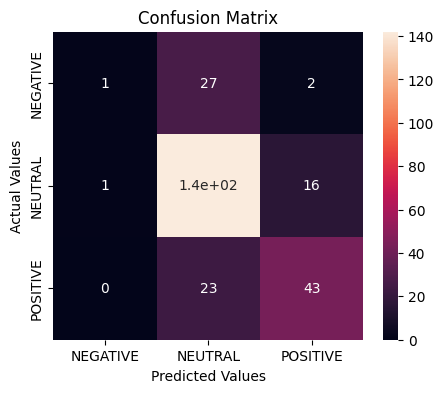

In [ ]:
#Plotting the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
f1_score(preds['Label'], preds['Predictions'], average=None)

array([0.0625    , 0.80911681, 0.67716535])

# Test Data Predictions using Partial Model

In [ ]:
@torch.no_grad()
def inference(test_loader, model, device):
  preds = []
  model.eval()
  model.to(device)
  all_ids = []
  bar = tqdm(enumerate(test_loader), total=len(test_loader))
  for step, data in bar:
    batch_ids = data['batch_id'].detach().cpu().numpy()
    ids = data['input_ids'].to(device, dtype = torch.long)
    mask = data['attention_mask'].to(device, dtype = torch.long)

    outputs = model(ids, mask)
    all_ids.extend(batch_ids)

    preds.extend(outputs.detach().cpu().numpy())

  preds = np.vstack(preds)

  return all_ids , preds

In [ ]:
df_test['Label'] = encoder.fit_transform(df_test['Label'])
test_dataset = TextDataset(df_test.reset_index(drop=True), tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)

In [ ]:
for fold in range(CONFIG['n_fold']):
  print(f"########### FOLD RUNNING {fold} ################ ")
  model = TextModel(CONFIG['model_name'])
  model_name = f"/content/Loss-Fold-{fold}.bin"
  checkpoint = torch.load(model_name)
  model.load_state_dict(checkpoint)
  batch_ids, preds = inference(test_loader, model, CONFIG['device'] )
  if fold == 0:
    final_preds = preds * (1/CONFIG['n_fold'])

  else:
    final_preds += preds * (1/CONFIG['n_fold'])
  del model
  gc.collect()
  torch.cuda.empty_cache()

########### FOLD RUNNING 0 ################ 


  0%|          | 0/8 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


########### FOLD RUNNING 1 ################ 


  0%|          | 0/8 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


########### FOLD RUNNING 2 ################ 


  0%|          | 0/8 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 8/8 [00:02<00:00,  3.61it/s]


In [ ]:
preds_df = pd.DataFrame({'ID':batch_ids, 'Predictions': final_preds.argmax(axis=1)})

In [ ]:
test_pred_df = pd.merge(df_test, preds_df, on= 'ID')
test_pred_df.to_csv('test_pred_df.csv')

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_pred_df['Label'], test_pred_df['Predictions'])
cm_df = pd.DataFrame(cm,
                     index = data,
                     columns = data)

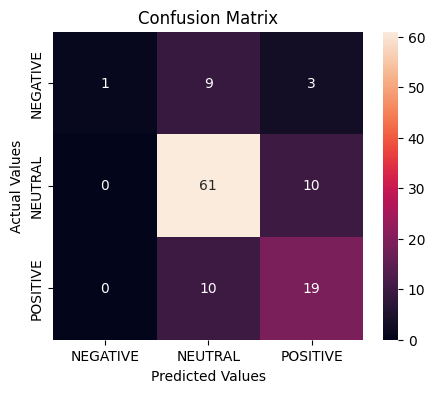

In [ ]:
#Plotting the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
f1_score(test_pred_df['Label'], test_pred_df['Predictions'], average=None)

array([0.14285714, 0.80794702, 0.62295082])